In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
file_path = './../../Fed1_dataset/Interest_rate_prediction.csv'

# FED_ir의 의미 : FED interest rate
df_irp = pd.read_csv(file_path)

df_irp.head()

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2008-12-01,0.25,0.0,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of Minnea...,0.080,0.839,0.082,0.9133,2008-12
1,2009-01-01,0.25,0.0,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-02-01,0.25,0.0,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-02
3,2009-03-01,0.25,0.0,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,1.50,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-03
4,2009-04-01,0.25,0.0,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04


전처리

In [4]:
df_irp['DATE'] = pd.to_datetime(df_irp['DATE']) # 날짤형으로 변환

In [5]:
df_irp.dtypes

DATE            datetime64[ns]
DFEDTARU               float64
DFEDTARL               float64
IR_FORCAST             float64
GDPGR                  float64
UNRATE                 float64
PCEPI                  float64
TNX                    float64
USD                    float64
KR_IR                  float64
ECB_IR                 float64
BB_text                 object
BB_neg                 float64
BB_neu                 float64
BB_pos                 float64
BB_sentiment           float64
DATE_YM                 object
dtype: object

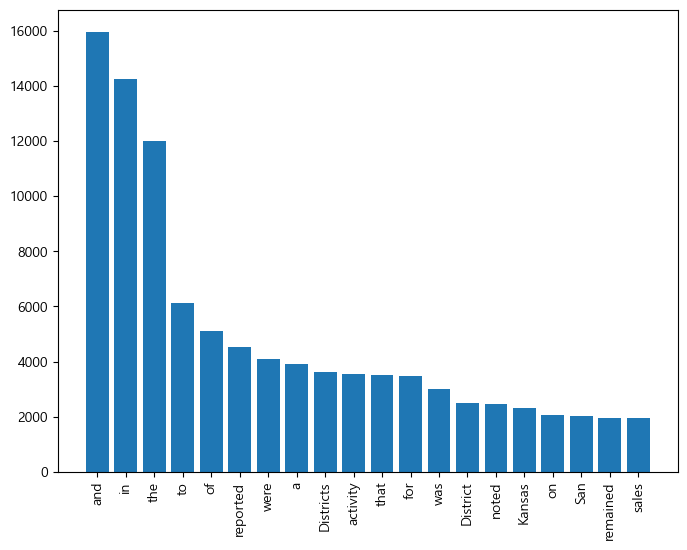

In [6]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [7]:
df_irp['BB_text'] = df_irp['BB_text'].str.lower()  # 소문자로
df_irp['BB_text'] = df_irp['BB_text'].str.strip()  # 앞뒤 공백 제거
df_irp['BB_text'] = df_irp['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
# 숫자, 대문자, 소문자 알파벳 및 공백을 제외한 모든 문자 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [8]:
# 불용어 제거
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_irp['BB_text'] = df_irp['BB_text'].apply(remove_stopwords)

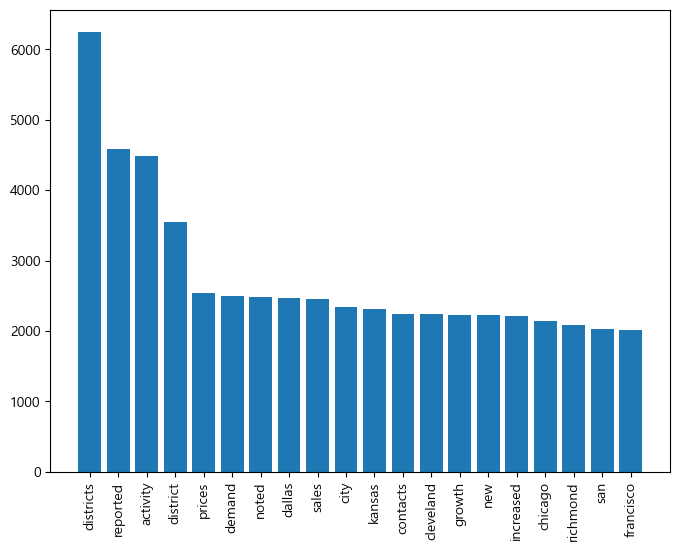

In [9]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

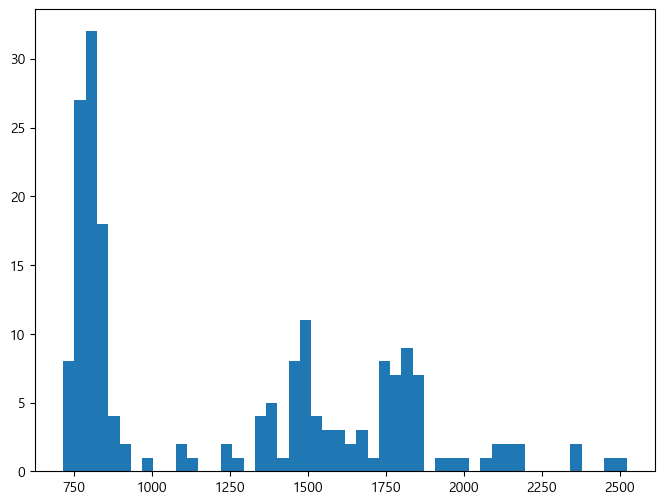

In [14]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

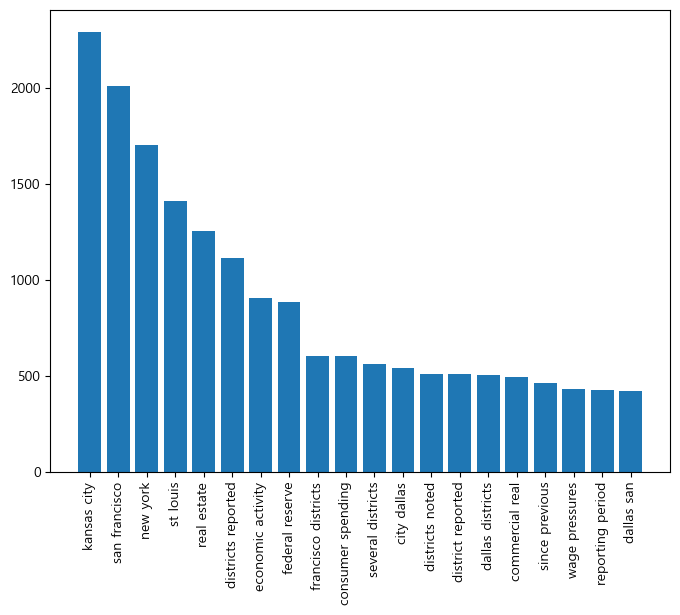

In [18]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

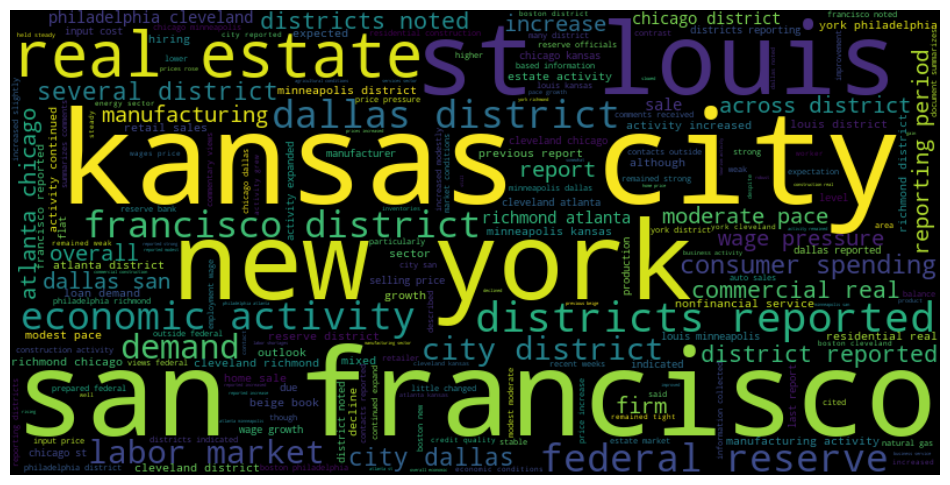

In [21]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# 연방준비은행 지역 목록 제거st louis와 같은 경우도 감안
federal_reserve_banks = [
    "boston", 
    "new york", 
    "philadelphia", 
    "cleveland", 
    "richmond", 
    "atlanta", 
    "chicago", 
    "st. louis", 
    "minneapolis", 
    "kansas city", 
    "dallas", 
    "san francisco",
    "st",
    "louis"
]

# 연방준비은행 지역 필터링 함수
def remove_federal_reserve_banks(text, bank_list):
    # 소문자 변환 및 정규표현식을 사용하여 지역 이름 제거
    for bank in bank_list:
        bank_pattern = re.compile(re.escape(bank), re.IGNORECASE)
        text = bank_pattern.sub('', text)
    return text

# 연방준비은행 지역 제거
df_irp['BB_text'] = df_irp['BB_text'].apply(lambda x: remove_federal_reserve_banks(x, federal_reserve_banks))

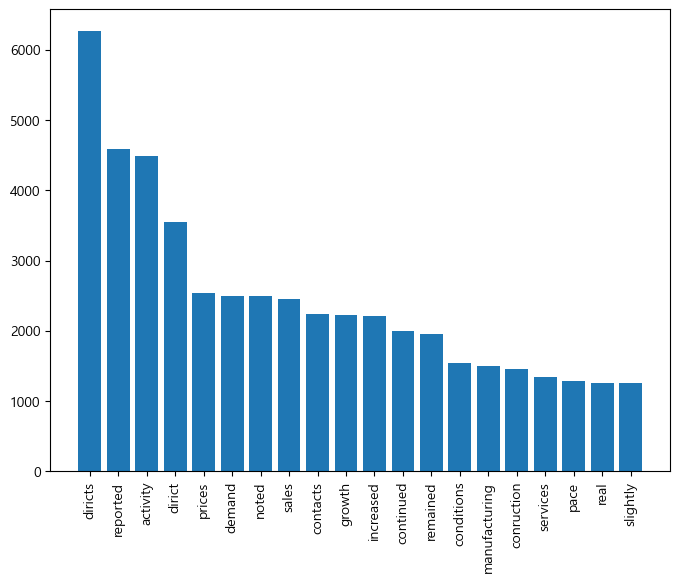

In [24]:
# 접속사들이 주로 나와서 전처리 필요
plt.figure(figsize=(8,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_irp['BB_text']).split())

# 상위 20개 단어 시각화
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

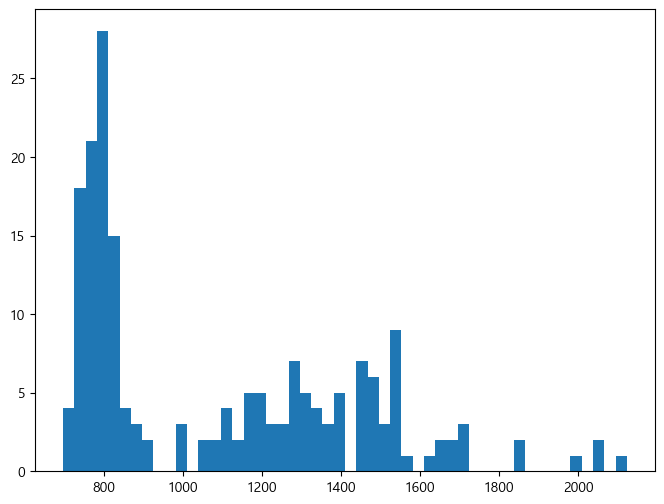

In [25]:
plt.figure(figsize=(8,6))

# 문서 길이 계산
df_irp['text_length'] = df_irp['BB_text'].apply(lambda x: len(x.split()))

# 문서 길이 분포 시각화
plt.hist(df_irp['text_length'], bins=50)
plt.show()

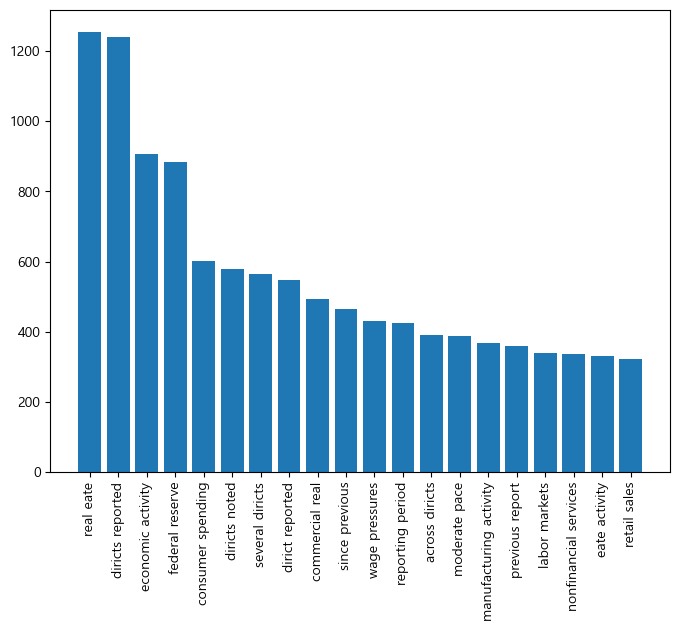

In [26]:
plt.figure(figsize=(8,6))

# 바이그램 분석
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(df_irp['BB_text'])

# 상위 20개 바이그램 시각화
bi_grams = X2.sum(axis=0).A1
bi_gram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), bi_grams)))
common_bi_grams = bi_gram_counts.most_common(20)

bi_grams, counts = zip(*common_bi_grams)

plt.bar(bi_grams, counts)
plt.xticks(rotation=90)
plt.show()

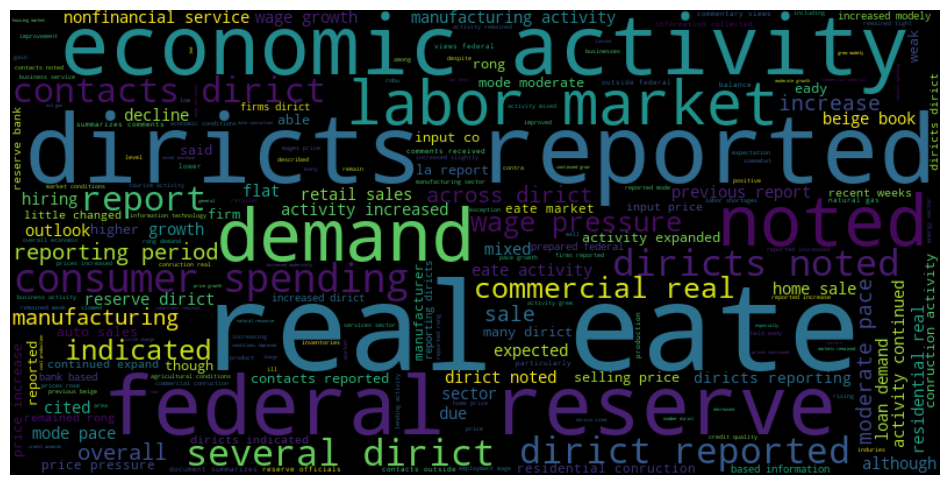

In [29]:
# 단어 빈도 기반 WordCloud 생성
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_irp['BB_text']))

plt.figure(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

감정분석 : 전처리 이전과 이후 비교

In [34]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dybae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df_irp[['f_neg', 'f_neu', 'f_pos', 'f_sentiment']] = df_irp['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

df_irp

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,...,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM,text_length,f_neg,f_neu,f_pos,f_sentiment
0,2008-12-01,0.25,0.00,0.50,-8.5,7.3,88.098,2.244,1259.5,3.0,...,0.080,0.839,0.082,0.9133,2008-12,916,0.111,0.804,0.085,-0.9594
1,2009-01-01,0.25,0.00,0.25,-4.5,7.8,88.108,2.844,1379.5,2.5,...,0.061,0.865,0.074,0.9952,2009-01,1451,0.109,0.787,0.103,-0.6317
2,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,3.041,1534.0,2.0,...,0.061,0.865,0.074,0.9952,2009-02,1451,0.109,0.787,0.103,-0.6317
3,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,2.685,1383.5,2.0,...,0.083,0.839,0.078,0.5459,2009-03,1376,0.116,0.786,0.098,-0.8791
4,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,3.124,1282.0,2.0,...,0.092,0.826,0.082,-0.6999,2009-04,1295,0.124,0.779,0.097,-0.9705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.206,1347.2,3.5,...,0.056,0.797,0.147,0.9991,2024-03,824,0.067,0.793,0.141,0.9966
184,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.109,4.686,1382.0,3.5,...,0.068,0.807,0.126,0.9974,2024-04,790,0.071,0.813,0.117,0.9886
185,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.146,4.514,1384.5,3.5,...,0.076,0.783,0.141,0.9982,2024-05,817,0.072,0.794,0.135,0.9953
186,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.243,4.343,1376.7,3.5,...,0.076,0.783,0.141,0.9982,2024-06,817,0.072,0.794,0.135,0.9953


RNN

In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
# 과거 데이터를 통해 미래데이터를 예측하기 때문에 MinMaxScaler 사용
def fit_trans(factor):
    scaler = MinMaxScaler()
    df_irp_new[factor] = scaler.fit_transform(df_irp_new[[factor]])
    df_irp_new['DFEDTARU'] = scaler.fit_transform(df_irp_new[['DFEDTARU']])
    data = df_irp_new[[factor, 'DFEDTARU']].values
    
    return data,scaler

In [41]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 1])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y    

In [98]:
def model_fit_predict(X,y,scaler) :
    
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # LSTM과의 차이:해당코드 무 model = Sequential()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = 'acc')
    
    # 검증 정확도 2번 개선 없으면 stop
    early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,callbacks=[early_stop])

    y_pred = model.predict(X_test)
    # Rescale the predictions and true values back to the original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]
    
    # Print the predicted and actual values
    #print("Predicted DFEDTARU values:")
    #print(y_pred_rescaled)
    #print("Actual DFEDTARU values:")
    #print(y_test_rescaled)

    return model

In [75]:
def future_predict(df,scaled_df,model,factor) :

    dic_irp = {
        'DATE': '일자',
        'DFEDTARU': '연준 기준 금리 상한',
        'DFEDTARL': '연준 기준 금리 하한',
        'IR_FORCAST': '연준 기준 금리 예측치',
        'GDPGR': '실질 국내총생산 성장률',
        'UNRATE': '실업률',
        'PCEPI': '개인 소비 지출: 체인형 가격 지수',
        'TNX': '명목이자율',
        'USD': '한은 USD환율',
        'KR_IR': '한은 기준 금리',
        'ECB_IR': 'ECB 기준 금리',
        'f_sentiment': 'Beige book 감정'
    }
    
    # 2024년 8월부터 12월까지 예측
    future_dates = pd.date_range(start='2024-08-01', end='2024-12-01', freq='MS')
    future_predictions = []
    
    last_sequence = X[-1]  # 가장 최근의 시퀀스 가져오기
    
    for _ in range(len(future_dates)):
        next_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
        future_predictions.append(next_pred[0, 0])
        # 새롭게 예측된 값을 시퀀스에 추가하고 첫 번째 값 제거
        last_sequence = np.append(last_sequence[1:], next_pred, axis=0)
    
    # 예측값 역정규화
    future_predictions_rescaled = scaler.inverse_transform(
        np.concatenate((np.zeros((len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, 1]
    #print(dic_irp.get(factor))
    # 예측된 미래 데이터프레임 생성
    future_df = pd.DataFrame({
        '요인명':[dic_irp.get(factor)],
        '실제값': [5.25],
        '예측값': [round(future_predictions_rescaled[0], 5)],
        '차이': [round(5.25 - future_predictions_rescaled[0], 5)] 
    })
    
    # 기존 파일에서 데이터 읽어오기 (파일이 존재하지 않는 경우 예외 처리)
    try:
        existing_df = pd.read_csv('./result_Dong_factor_202408.csv')
        combined_df = pd.concat([existing_df, future_df], ignore_index=True)
    except FileNotFoundError:
        combined_df = future_df
    
    # 결과를 CSV 파일로 저장
    combined_df.to_csv('./result_Dong_factor_202408.csv', index=False,encoding='utf-8-sig')

개별 요인별 평가
lst_factor = ['IR_FORCAST', 'GDPGR', 'UNRATE', 'PCEPI', 'TNX', 'USD', 'KR_IR', 'ECB_IR', 'f_sentiment']로 할 경우 아래 코드들이 작동하지 않아
개별로 처리
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 1))), axis=1))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

In [161]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['IR_FORCAST']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 52ms/step - loss: 0.0395 - acc: 0.5827 - val_loss: 0.0170 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0501 - acc: 0.5906 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0406 - acc: 0.5827 - val_loss: 0.1394 - val_acc: 0.6667
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0358 - acc: 0.5906 - val_loss: 0.0214 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0202 - acc: 0.5984 - val_loss: 0.0253 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0247 - acc: 0.5984 - val_loss: 0.0194 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0091 - acc: 0.5906 - val_loss: 0.0497 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0128 - acc: 0.5906 - va

In [162]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['GDPGR']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 52ms/step - loss: 0.3509 - acc: 0.4252 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2135 - acc: 0.5276 - val_loss: 0.0279 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1677 - acc: 0.5276 - val_loss: 0.0553 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1466 - acc: 0.5118 - val_loss: 0.0426 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1295 - acc: 0.5669 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1062 - acc: 0.5827 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0947 - acc: 0.5591 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0804 - acc: 0.5512 - va

In [163]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['UNRATE']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 0.4229 - acc: 0.4173 - val_loss: 0.2721 - val_acc: 0.8667
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1705 - acc: 0.5276 - val_loss: 0.2122 - val_acc: 0.8000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1752 - acc: 0.4016 - val_loss: 0.1203 - val_acc: 0.8667
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0747 - acc: 0.5748 - val_loss: 0.1361 - val_acc: 0.8667
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0852 - acc: 0.5984 - val_loss: 0.1142 - val_acc: 0.8667
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0752 - acc: 0.5906 - val_loss: 0.0889 - val_acc: 0.8667
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0599 - acc: 0.5512 - val_loss: 0.0996 - val_acc: 0.8667
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0387 - acc: 0.5906 - v

In [164]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['PCEPI']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 52ms/step - loss: 0.1297 - acc: 0.5039 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0778 - acc: 0.5984 - val_loss: 0.0247 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0583 - acc: 0.5827 - val_loss: 0.1451 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0317 - acc: 0.5906 - val_loss: 0.0206 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0354 - acc: 0.5984 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0203 - acc: 0.5984 - val_loss: 0.0933 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0228 - acc: 0.5984 - val_loss: 0.0849 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0145 - acc: 0.5984 - va

In [165]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['TNX']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 56ms/step - loss: 0.1869 - acc: 0.4961 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1379 - acc: 0.5669 - val_loss: 0.0167 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1176 - acc: 0.4882 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0935 - acc: 0.5748 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0886 - acc: 0.5433 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0593 - acc: 0.5827 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0730 - acc: 0.5748 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0528 - acc: 0.5827 - va

In [166]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['USD']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 54ms/step - loss: 0.1636 - acc: 0.5669 - val_loss: 0.3797 - val_acc: 0.0667
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1134 - acc: 0.4882 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0802 - acc: 0.5984 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0579 - acc: 0.5984 - val_loss: 0.0394 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0573 - acc: 0.5669 - val_loss: 0.0511 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0394 - acc: 0.5906 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0325 - acc: 0.5984 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0388 - acc: 0.5984 - va

In [167]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['KR_IR']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 53ms/step - loss: 0.1359 - acc: 0.5354 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1601 - acc: 0.5354 - val_loss: 0.0527 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1248 - acc: 0.4961 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0962 - acc: 0.5748 - val_loss: 0.0495 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0961 - acc: 0.5118 - val_loss: 0.0136 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0842 - acc: 0.5984 - val_loss: 0.0299 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0583 - acc: 0.5906 - val_loss: 0.0457 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0563 - acc: 0.5827 - va

In [168]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['ECB_IR']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 55ms/step - loss: 0.0836 - acc: 0.5433 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0432 - acc: 0.5984 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0422 - acc: 0.5984 - val_loss: 0.0377 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0409 - acc: 0.5906 - val_loss: 0.0327 - val_acc: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0248 - acc: 0.5984 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0270 - acc: 0.5984 - val_loss: 0.0260 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0227 - acc: 0.5984 - val_loss: 0.0283 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0217 - acc: 0.5984 - va

In [170]:
import pandas as pd

# 기존 데이터프레임 df_irp_new
df_irp_new = df_irp[['DATE', 'DFEDTARU']].copy()

# 추가할 컬럼 리스트로 해당코드들은 딕셔너리(dic_irp)로 매핑하여 한글로 csv작성
lst_factor = ['f_sentiment']

# 루프를 통해 새로운 데이터프레임 생성
for factor in lst_factor:
    df_irp_new.loc[:, factor] = df_irp[factor]
    
    scaled_df_irp,scaler = fit_trans(factor)
    # 결과 출력
    sequence_length = 10 # 과거 10개 데이터 사용
    X,y = create_sequences(scaled_df_irp, sequence_length)
    model = model_fit_predict(X,y,scaler)
    future_predict(df_irp,scaled_df_irp,model,factor)
    # 기존 컬럼 삭제
    df_irp_new.drop(df_irp_new.columns[2], axis=1, inplace=True)

Epoch 1/100
4/4 [==============================] - 1s 53ms/step - loss: 0.3741 - acc: 0.4724 - val_loss: 0.0767 - val_acc: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.2089 - acc: 0.4724 - val_loss: 0.1327 - val_acc: 0.8667
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1717 - acc: 0.5118 - val_loss: 0.0591 - val_acc: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2018 - acc: 0.5276 - val_loss: 0.0733 - val_acc: 0.9333
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1954 - acc: 0.4173 - val_loss: 0.0237 - val_acc: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.1601 - acc: 0.5748 - val_loss: 0.0217 - val_acc: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1283 - acc: 0.5669 - val_loss: 0.0788 - val_acc: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1637 - acc: 0.4567 - v

여러번 실행 후 취합 하여 최종 저장

In [179]:
df_result = pd.read_csv('./result_Dong_factor_202408.csv')
df_result

,요인명,실제값,예측값,차이
0,연준 기준 금리 예측치,5.25,5.01949,0.23051
1,실질 국내총생산 성장률,5.25,0.75952,4.49048
2,실업률,5.25,1.92934,3.32066
3,개인 소비 지출: 체인형 가격 지수,5.25,4.04147,1.20853
4,명목이자율,5.25,0.76364,4.48636
5,한은 USD환율,5.25,1.14302,4.10698
6,한은 기준 금리,5.25,0.21078,5.03922
7,ECB 기준 금리,5.25,-1.41994,6.66994
8,Beige book 감정,5.25,0.73656,4.51344
9,연준 기준 금리 예측치,5.25,4.46747,0.78253


In [193]:
df_avg = df_result.groupby('요인명', sort=False).mean()

df_avg.to_csv('./result_Dong_factor_avg_202408.csv', index=True, encoding='utf-8-sig')

print(df_avg)

                      실제값       예측값        차이
요인명                                          
연준 기준 금리 예측치         5.25  4.578943  0.671057
실질 국내총생산 성장률         5.25  0.764373  4.485627
실업률                  5.25  1.819027  3.430973
개인 소비 지출: 체인형 가격 지수  5.25  4.292657  0.957343
명목이자율                5.25  0.810477  4.439523
한은 USD환율             5.25  1.199563  4.050437
한은 기준 금리             5.25 -0.026977  5.276977
ECB 기준 금리            5.25 -1.056333  6.306333
Beige book 감정        5.25  0.706560  4.543440
